# 네이버 영화 리뷰 감성 분석

## import packge

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from konlpy.tag import Mecab
from collections import Counter
import re
import os

## 데이터 불러오기

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
train_data.shape

(150000, 3)

train셋
- 150,000개의 리뷰로 구성됨
- 3개의 columns는 id, document(리뷰 내용), label로 구성됨
- label
    - 0 : 부정적인 리뷰
    - 1 : 긍정적인 리뷰

In [4]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
test_data.shape

(50000, 3)

test셋
- 50,000개의 리뷰로 구성됨
- columns 구성은 train셋과 동일함

## 데이터 살펴보기

### 1. 결측치 확인

In [6]:
train_data.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [7]:
train_data[train_data['document'].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [8]:
test_data.isnull().sum()

id          0
document    3
label       0
dtype: int64

In [9]:
test_data[test_data['document'].isnull()]

,id,document,label
5746,402110,NaN,1
7899,5026896,NaN,0
27097,511097,NaN,1


- 결측치는 train셋에 5개, test셋에 3개 존재
- document 내용으로 분석해야하기 때문에 결측치에 대한 데이터는 삭제할 예정

In [10]:
train_data.dropna(axis=0, inplace=True)

In [11]:
test_data.dropna(axis=0, inplace=True)

In [12]:
train_data.shape, test_data.shape

((149995, 3), (49997, 3))

- train셋과 test셋에서 결측치가 있는 row를 모두 삭제함
- train셋 5개 삭제, test셋 3개 삭제

### 2.중복 데이터 확인

In [13]:
train_data[train_data.duplicated(subset=['document'])].head()

,id,document,label
1058,5890638,4,0
1097,2062443,쵝오,1
1248,3502685,최고,1
1483,775332,최고,1
1707,8009134,재밌다,1


In [14]:
test_data[test_data.duplicated(subset=['document'])].head()

,id,document,label
857,2084375,bad,0
956,195683,재미있어요,1
1089,2235528,볼만함,1
1149,4409686,굿,1
1600,3805716,최고,1


- duplicated()로 본 결과, train셋과 test셋에 중복이 존재함

In [15]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [16]:
test_data.drop_duplicates(subset=['document'], inplace=True)

In [17]:
train_data.shape, test_data.shape

((146182, 3), (49157, 3))

- 중복을 drop_duplicates으로 제거함 (중복된 것 중, 디폴트값에 의해 첫번째만 남고 나머지 제거됨)
- 중복 제거된 train과 test는 146,182개, 49,157개의 데이터가 있음

## Data loader 만들기

### 1. Mecab() 알아보기

In [18]:
tokenizer = Mecab()

In [19]:
tokenizer.morphs("테스트. 나는 강태원입니다. 당신은 누구십니까?")

['테스트', '.', '나', '는', '강태원', '입니다', '.', '당신', '은', '누구', '십니까', '?']

In [20]:
tokenizer.pos("테스트. 나는 강태원입니다. 당신은 누구십니까?")

[('테스트', 'NNG'),
 ('.', 'SF'),
 ('나', 'NP'),
 ('는', 'JX'),
 ('강태원', 'NNP'),
 ('입니다', 'VCP+EF'),
 ('.', 'SF'),
 ('당신', 'NP'),
 ('은', 'JX'),
 ('누구', 'NP'),
 ('십니까', 'VCP+EP+EF'),
 ('?', 'SF')]

- morphs : 토큰만 뽑아냄
- pos : 토큰의 형태도 출력함

### 2. 토큰 추출 및 데이터셋에 'token' column 추가

In [21]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

- 불용어 리스트를 지정
- 불용어에 해당하는 토큰은 제외하고자 함

In [22]:
word_list = []

train_data['token'] = 0

for sentence, idx in zip(train_data['document'], train_data.index):
    sentence = re.sub(r"[^가-힣a-zA-Z]+", " ", str(sentence))  # 정규식을 통해 (가-힣, a-z, A-Z, 0-9)가 아닌 것은 없앰
    senten_token = tokenizer.morphs(sentence)  # 문장에서 토큰 추출
    
    good_senten_token = []
    for token in senten_token:
        
        if token in stopwords:  # 불용어에 해당하는 토큰은 continue를 통해 제외함
            continue
            
        else:
            good_senten_token.append(token)  # 불용어에 해당하지 않는 토큰은 good_senten_token에 추가함
            
    train_data['token'][idx] = good_senten_token  # good_senten_token : 'token' column에 토큰들의 리스트를 추가
    
    for word in good_senten_token:   # good_senten_token에 들어있는 토큰들을 word_list에 추가
        word_list.append(word)

/tmp/ipykernel_6767/2766228128.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['token'][idx] = good_senten_token  # good_senten_token : 'token' column에 토큰들의 리스트를 추가
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


- re.sub(r"[^가-힣a-zA-Z]+", " ", str(sentence) : 정규식을 통해 (가-힣, a-z, A-Z)가 아닌 것은 없앰
- tokenizer.morphs(sentence) : 문장에서 토큰 추출
- if token in stopwords : 불용어에 해당하는 토큰은 continue를 통해 제외함
- good_senten_token.append(token) : 불용어에 해당하지 않는 토큰은 good_senten_token에 추가함
- train_data['token'][idx] : good_senten_token : 'token' column에 토큰들의 리스트를 추가
- word_list.append(word) : good_senten_token에 들어있는 토큰들을 word_list에 추가

In [23]:
test_data['token'] = 0

for sentence, idx in zip(test_data['document'], test_data.index):
    sentence = re.sub(r"[^가-힣a-zA-Z]+", " ", str(sentence))
    senten_token = tokenizer.morphs(sentence)
    
    good_senten_token = []
    for token in senten_token:
        
        if token in stopwords:
            continue
            
        else:
            good_senten_token.append(token)
            
    test_data['token'][idx] = good_senten_token

/tmp/ipykernel_6767/1273413689.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['token'][idx] = good_senten_token


In [24]:
train_data.head()

,id,document,label,token
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,"[아, 더, 빙, 진짜, 짜증, 나, 네요, 목소리]"
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,"[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 지, 않, 구나]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너무, 재, 밓었다그래서보는것을추천한다]"
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[교도소, 이야기, 구먼, 솔직히, 재미, 없, 다, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[사이몬페그, 익살, 스런, 연기, 돋보였, 던, 영화, 스파이더맨, 에서, 늙, ..."


In [25]:
test_data.head()

,id,document,label,token
0,6270596,굳 ㅋ,1,[굳]
1,9274899,GDNTOPCLASSINTHECLUB,0,[GDNTOPCLASSINTHECLUB]
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0,"[뭐, 야, 평점, 나쁘, 진, 않, 지만, 점, 짜리, 더더욱, 아니, 잖아]"
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0,"[지루, 하, 지, 않, 은데, 완전, 막장, 임, 돈, 주, 고, 보, 기]"
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0,"[D, 만, 아니, 었, 어도, 별, 다섯, 개, 줬, 을, 텐데, 왜, D, 로,..."


In [26]:
train_data.isnull().sum()

id          0
document    0
label       0
token       0
dtype: int64

In [27]:
test_data.isnull().sum()

id          0
document    0
label       0
token       0
dtype: int64

- train과 test에는 결측치가 없음

### 3. 모델에 들어갈 train셋과 test셋 분할

In [28]:
x_train = train_data['token']
y_train = train_data['label']

- train셋에서 feature와 label을 나눔

In [29]:
x_test = test_data['token']
y_test = test_data['label']

- test셋에서 feature와 label을 나눔

In [30]:
x_train.shape, y_train.shape

((146182,), (146182,))

In [31]:
x_test.shape, y_test.shape

((49157,), (49157,))

### 4. 토큰 가공

In [32]:
word_list[0]

'아'

In [33]:
counter = Counter(word_list)

- Counter()를 통해 word_list의 토큰들의 빈도 체크

In [34]:
counter = counter.most_common(10000-4)

- 가장 많이 사용된 토큰을 9,996개 뽑아둠 (3개는 \'\<PAD>': 0, \'\<BOS>': 1, \'\<UNK>': 2 로 채울 예정)

In [35]:
counter[0:4]

[('영화', 57417), ('다', 54780), ('고', 47303), ('하', 44683)]

In [36]:
count_list = []
for i, j in counter:
    count_list.append(i)

In [37]:
len(count_list)

9996

### 5. 토큰을 딕셔너리로 묶음

In [38]:
word_to_index={}

word_to_index['<PAD>'] = 0  # 패딩이 들어갈 자리
word_to_index['<BOS>'] = 1  # 문장의 시작을 알리는 토큰
word_to_index['<UNK>'] = 2  # 빈도수 기준 9,996개에 들어가지 못한 토큰들은 UNK로 표현될 예정

for idx, word in enumerate(count_list):
    word_to_index[word]=idx+3

In [39]:
word_to_index['<PAD>']

0

- 토큰을 key값으로 하고 인덱스를 value로 가지는 딕셔너리 생성

In [40]:
# index_to_word

In [41]:
len(word_to_index)

9999

In [42]:
index_to_word = {index:word for word, index in word_to_index.items()}

- 인덱스를 key값으로 하고 토큰을 value로 가지는 딕셔너리 생성

In [43]:
len(index_to_word)

9999

## 인코딩과 디코딩 함수 만들기

In [44]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence]

- 문장 1개를 인덱스 리스트 벡터로 인코딩하는 함수입니다. 
- 모든 문장은 \<BOS>로 시작함

In [45]:
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

- 문장 여러개를 인덱스 리스트 벡터로 인코딩하는 함수입니다.

In [46]:
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

- 인코딩된 벡터 1개를 문장으로 디코딩하는 함수

In [47]:
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

- 인코딩된 벡터 여러개를 문장들로 디코딩하는 함수

## 시퀀스 만들기

### 1. 인코딩하기

In [48]:
x_train_encode = get_encoded_sentences(x_train, word_to_index)

In [49]:
x_train_encode[0]

[1, 26, 64, 880, 32, 207, 14, 27, 691]

In [50]:
x_test_encode = get_encoded_sentences(x_test, word_to_index)

In [51]:
x_test_encode[0]

[1, 768]

### 2. 시퀀스 길이 정하기

In [52]:
total_data_text = list(x_train_encode) + list(x_test_encode)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  14.639053133270878
문장길이 최대 :  106
문장길이 표준편차 :  11.465804944898359
pad_sequences maxlen :  37
전체 문장의 0.934278357112507%가 maxlen 설정값 이내에 포함됩니다. 


시퀀스의 길이는 : 37로 정함

### 3. 패딩하기
- 패딩은 pre-padding을 적용함
    - pre-padding : 시퀀스의 길이만큼 채우기 위한 0의 값을 앞에서부터 채움
    - RNN으로 모델이 학습할 때, 마지막에 의미없는 0으로 끝나지 않게 함

In [53]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train_encode,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test_encode,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 37)


## Train셋에서 Train과 Validation으로 나누기
- train : 모델 학습에 필요
- validation
    - test에 평가해보기 전에 성능 체크
    - 하이퍼 파라미터 조정을 할 수 있도록 validation을 둠

In [54]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 37)
(136182,)


- 학습에 들어갈 train셋은 136,182개
- 시퀀스의 길이는 37

## 모델 1 - RNN (LSTM)

### 1. 모델 만들기

In [55]:
vocab_size = 9999    # 어휘 사전의 크기입니다(9999 게의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          159984    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,865
Trainable params: 160,865
Non-trainable params: 0
_________________________________________________________________


- **Embedding**
    - input : 단어 사전수만큼을 vocab_size로 지정해서 넣음
    - output : 컴퓨터가 이해할 수 있도록 숫자로 된 벡터 차원 수로 word_vector_dim으로 지정해서 넣음
    - input_shape는 1차원 벡터의 형태이므로 벡터형태 표기 (현재에서는 생략 가능)

### 2. 모델 학습시키기

In [56]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/8
266/266 [==============================] - 5s 7ms/step - loss: 0.5084 - accuracy: 0.7848 - val_loss: 0.3772 - val_accuracy: 0.8392
Epoch 2/8
266/266 [==============================] - 1s 5ms/step - loss: 0.3550 - accuracy: 0.8494 - val_loss: 0.3586 - val_accuracy: 0.8427
Epoch 3/8
266/266 [==============================] - 1s 5ms/step - loss: 0.3334 - accuracy: 0.8595 - val_loss: 0.3563 - val_accuracy: 0.8435
Epoch 4/8
266/266 [==============================] - 1s 5ms/step - loss: 0.3218 - accuracy: 0.8647 - val_loss: 0.3592 - val_accuracy: 0.8447
Epoch 5/8
266/266 [==============================] - 1s 5ms/step - loss: 0.3142 - accuracy: 0.8688 - val_loss: 0.3584 - val_accuracy: 0.8433
Epoch 6/8
266/266 [==============================] - 1s 5ms/step - loss: 0.3057 - accuracy: 0.8726 - val_loss: 0.3625 - val_accuracy: 0.8403
Epoch 7/8
266/266 [==============================] - 1s 5ms/step - loss: 0.2972 - accuracy: 0.8774 - val_loss: 0.3629 - val_accuracy: 0.8423
Epoch 8/8
266

- loss funtion은 2진 분류(긍적평가, 부정평가)이므로 binary_crossentropy를 사용

### 3. test셋에 평가

In [57]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3806 - accuracy: 0.8398
[0.3805934488773346, 0.8398396968841553]


- test셋에 평가
- loss : 약 0.37
- accuracy : 약 83.9%

### 4. 그래프로 시각화하여 loss와 accuarcy 흐름 파악

In [58]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [59]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

Text(0, 0.5, 'Loss')

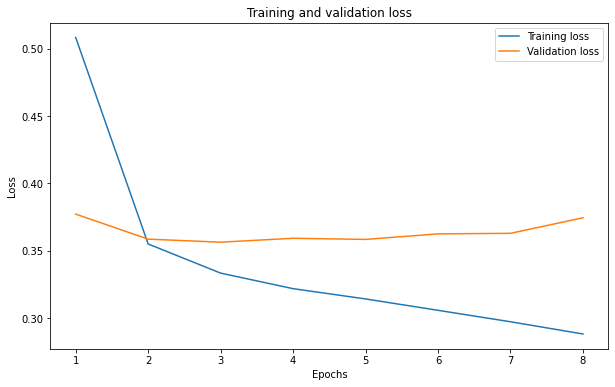

In [60]:
plt.figure(figsize=(10,6))
sns.lineplot(data=history_dict, x=epochs, y=loss, label='Training loss')
sns.lineplot(data=history_dict, x=epochs, y=val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

- 학습이 진행될수록 train loss는 줄어들음
- 3번째 epoch에서 validation의 loss는 늘어나기 시작함
- 3번째 epoch부터 overfitting이 시작됨

Text(0, 0.5, 'Accuracy')

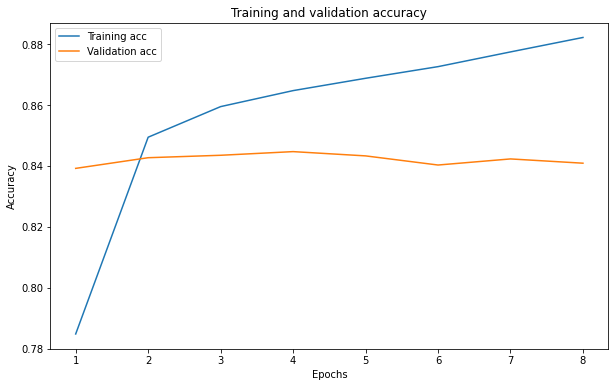

In [61]:
plt.figure(figsize=(10,6))
sns.lineplot(data=history_dict, x=epochs, y=acc, label='Training acc')
sns.lineplot(data=history_dict, x=epochs, y=val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

- 학습이 진행될수록 train accuracy는 올라감
- 4번째 epoch에서 validation의 accuracy는 변화가 거의 없음
- 4번째 epoch부터 overfitting이 시작됨

## 모델 2 - RNN (LSTM을 두개 쓰기)

### 1. 모델 만들기

In [62]:
vocab_size = 9999    # 어휘 사전의 크기입니다(9999개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_rnn2 = tf.keras.Sequential()
model_rnn2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn2.add(tf.keras.layers.LSTM(8, return_sequences=True))
model_rnn2.add(tf.keras.layers.LSTM(8))
model_rnn2.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_rnn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          159984    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 8)           800       
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 161,409
Trainable params: 161,409
Non-trainable params: 0
_________________________________________________________________


- return_sequences=True : 한개의 신경망이 한번 돌고 다음 신경망을 돌림 (모두 다 돌아간 이후에 다음 신경망으로 가지 않음)

### 2. 모델 학습시키기

In [63]:
model_rnn2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_rnn2 = model_rnn2.fit(partial_x_train,
                              partial_y_train,
                              epochs=epochs,
                              batch_size=512,
                              validation_data=(x_val, y_val),
                              verbose=1)

Epoch 1/8
266/266 [==============================] - 5s 10ms/step - loss: 0.5063 - accuracy: 0.7517 - val_loss: 0.3738 - val_accuracy: 0.8385
Epoch 2/8
266/266 [==============================] - 2s 7ms/step - loss: 0.3514 - accuracy: 0.8489 - val_loss: 0.3516 - val_accuracy: 0.8457
Epoch 3/8
266/266 [==============================] - 2s 7ms/step - loss: 0.3278 - accuracy: 0.8598 - val_loss: 0.3478 - val_accuracy: 0.8466
Epoch 4/8
266/266 [==============================] - 2s 7ms/step - loss: 0.3137 - accuracy: 0.8663 - val_loss: 0.3483 - val_accuracy: 0.8462
Epoch 5/8
266/266 [==============================] - 2s 7ms/step - loss: 0.3024 - accuracy: 0.8713 - val_loss: 0.3486 - val_accuracy: 0.8478
Epoch 6/8
266/266 [==============================] - 2s 7ms/step - loss: 0.2897 - accuracy: 0.8766 - val_loss: 0.3501 - val_accuracy: 0.8492
Epoch 7/8
266/266 [==============================] - 2s 7ms/step - loss: 0.2774 - accuracy: 0.8825 - val_loss: 0.3566 - val_accuracy: 0.8457
Epoch 8/8
26

- loss funtion은 2진 분류(긍적평가, 부정평가)이므로 binary_crossentropy를 사용

### 3. test셋에 평가

In [64]:
results_rnn2 = model_rnn2.evaluate(x_test,  y_test, verbose=2)

print(results_rnn2)

1537/1537 - 4s - loss: 0.3755 - accuracy: 0.8402
[0.375457763671875, 0.8402058482170105]


- test셋에 평가
- loss : 약 0.38
- accuracy : 약 84.0%

### 4. 그래프로 시각화하여 loss와 accuarcy 흐름 파악

In [65]:
history_dict_rnn2 = history_rnn2.history
print(history_dict_rnn2.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [66]:
acc = history_dict_rnn2['accuracy']
val_acc = history_dict_rnn2['val_accuracy']
loss = history_dict_rnn2['loss']
val_loss = history_dict_rnn2['val_loss']

epochs = range(1, len(acc) + 1)

Text(0, 0.5, 'Loss')

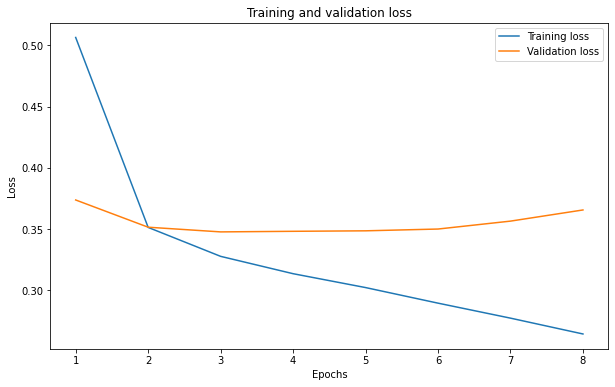

In [67]:
plt.figure(figsize=(10,6))
sns.lineplot(data=history_dict_rnn2, x=epochs, y=loss, label='Training loss')
sns.lineplot(data=history_dict_rnn2, x=epochs, y=val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

- 학습이 진행될수록 train loss는 줄어들음
- 3번째 epoch에서 validation의 loss는 늘어나기 시작함
- 3번째 epoch부터 overfitting이 시작됨

Text(0, 0.5, 'Accuracy')

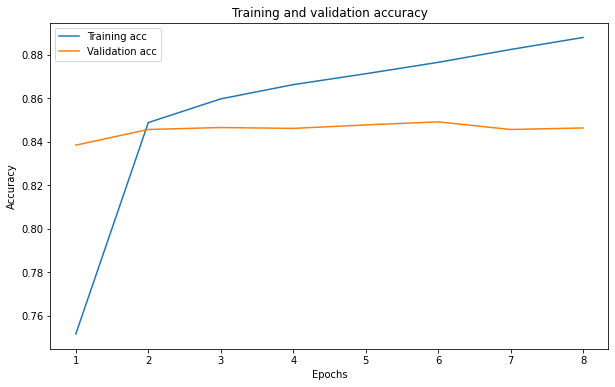

In [68]:
plt.figure(figsize=(10,6))
sns.lineplot(data=history_dict_rnn2, x=epochs, y=acc, label='Training acc')
sns.lineplot(data=history_dict_rnn2, x=epochs, y=val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

- 학습이 진행될수록 train accuracy는 올라감
- 3번째 epoch에서 validation의 accuracy의 변화는 별로 없음

## 모델 3 - CNN

### 1. 모델 만들기

In [69]:
vocab_size = 9999    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          159984    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 161,937
Trainable params: 161,937
Non-trainable params: 0
_________________________________________________________________


- 이미지와는 다르게 입력이 1차원 벡터로 되어있기 때문에 Conv1D, MaxPooling1D 사용
- Conv1D : 16개의 필터, 필터 사이즈는 7 (7단어)
- GlobalMaxPooling1D() : 문장 전체에서 가장 중요한 단어를 뽑아냄

### 2. 모델 학습시키기

In [70]:
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_cnn.fit(partial_x_train,
                            partial_y_train,
                            batch_size=512,
                            epochs=epochs,
                            validation_data=(x_val, y_val),
                            verbose=1)

Epoch 1/8
266/266 [==============================] - 3s 5ms/step - loss: 0.5066 - accuracy: 0.7594 - val_loss: 0.3628 - val_accuracy: 0.8371
Epoch 2/8
266/266 [==============================] - 1s 4ms/step - loss: 0.3424 - accuracy: 0.8515 - val_loss: 0.3473 - val_accuracy: 0.8454
Epoch 3/8
266/266 [==============================] - 1s 4ms/step - loss: 0.3090 - accuracy: 0.8693 - val_loss: 0.3445 - val_accuracy: 0.8472
Epoch 4/8
266/266 [==============================] - 1s 4ms/step - loss: 0.2844 - accuracy: 0.8827 - val_loss: 0.3485 - val_accuracy: 0.8508
Epoch 5/8
266/266 [==============================] - 1s 4ms/step - loss: 0.2612 - accuracy: 0.8941 - val_loss: 0.3594 - val_accuracy: 0.8480
Epoch 6/8
266/266 [==============================] - 1s 4ms/step - loss: 0.2371 - accuracy: 0.9070 - val_loss: 0.3733 - val_accuracy: 0.8426
Epoch 7/8
266/266 [==============================] - 1s 4ms/step - loss: 0.2126 - accuracy: 0.9190 - val_loss: 0.3947 - val_accuracy: 0.8405
Epoch 8/8
266

### 3. test셋에 평가

In [71]:
results_cnn = model_cnn.evaluate(x_test,  y_test, verbose=2)

print(results_cnn)

1537/1537 - 2s - loss: 0.4206 - accuracy: 0.8364
[0.4205872714519501, 0.8364017605781555]


- test셋에 평가
- loss : 약 0.42
- accuracy : 약 83.6%

### 4. 그래프로 시각화하여 loss와 accuarcy 흐름 파악

In [72]:
history_dict_cnn = history_cnn.history
print(history_dict_cnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [73]:
acc = history_dict_cnn['accuracy']
val_acc = history_dict_cnn['val_accuracy']
loss = history_dict_cnn['loss']
val_loss = history_dict_cnn['val_loss']

epochs = range(1, len(acc) + 1)

Text(0, 0.5, 'Loss')

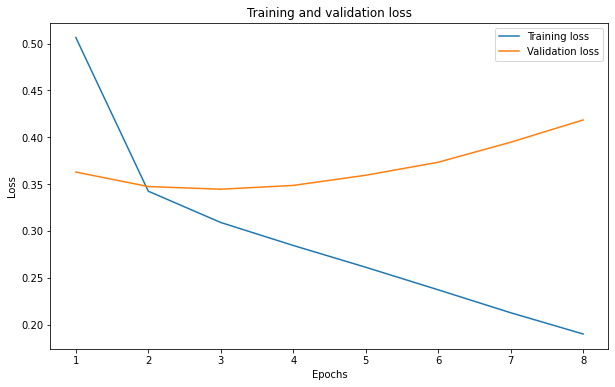

In [74]:
plt.figure(figsize=(10,6))
sns.lineplot(data=history_dict_cnn, x=epochs, y=loss, label='Training loss')
sns.lineplot(data=history_dict_cnn, x=epochs, y=val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

- 학습이 진행될수록 train loss는 줄어들음
- 3번째 epoch에서 validation의 loss는 늘어나기 시작함
- 3번째 epoch부터 overfitting이 시작됨

Text(0, 0.5, 'Accuracy')

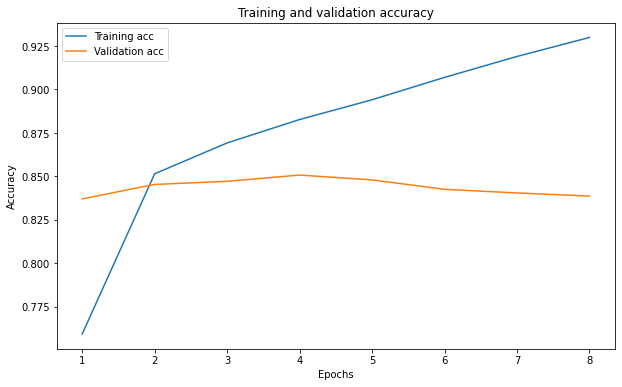

In [75]:
plt.figure(figsize=(10,6))
sns.lineplot(data=history_dict_cnn, x=epochs, y=acc, label='Training acc')
sns.lineplot(data=history_dict_cnn, x=epochs, y=val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

- 학습이 진행될수록 train accuracy는 올라감
- 4번째 epoch에서 validation의 accuracy는 서서히 줄어들음
- 4번째 epoch부터 overfitting이 시작됨

## 세가지 모델 비교
- RNN (LSTM)
- RNN (LSTM 두개)
- CNN

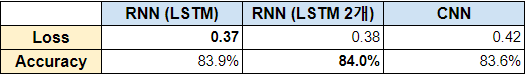

<결과>
- loss값은 RNN이 가장 작게 나옴
- accuracy는 RNN(LSTM 2개)가 가장 높게 나옴
- CNN은 모두 가장 높은 loss와 낮은 accuracy가 나옴
- 세가지 모델 모두 큰 차이는 없음

## gensim 패키지를 이용하여 유사단어 찾기

### 1. 자체 학습한 embedding

In [76]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(9999, 16)


In [77]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

- 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
- 파일명 : word2vec

In [78]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [79]:
vector = word_vectors['사랑']
vector

array([ 0.1192082 , -0.11890228, -0.02296213,  0.04987673,  0.1392197 ,
        0.09335904, -0.0991051 ,  0.11945079,  0.0481686 , -0.17206535,
       -0.13849124, -0.05985862, -0.12031361,  0.11352997,  0.08508775,
        0.06812623], dtype=float32)

In [93]:
word_vectors.similar_by_word("사랑")

[('놓치', 0.9644392728805542),
 ('뛰어났', 0.9631916880607605),
 ('조니뎁', 0.9618322849273682),
 ('똘', 0.9616032838821411),
 ('샀', 0.9593460559844971),
 ('이만큼', 0.9559633731842041),
 ('와우', 0.9556348323822021),
 ('치열', 0.9555698037147522),
 ('부른', 0.9553150534629822),
 ('싱크로', 0.9550693035125732)]

- 자체 학습한 Embedding에서는 제시어인 '사랑'과 무관한 단어들을 출력함

### 2. 사전 학습된 embedding

In [81]:
from gensim.models import Word2Vec
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

- gensim==3.4.0 버전으로 실행함

In [82]:
word2vec.similar_by_word("사랑")

/tmp/ipykernel_6767/1360476464.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

- 사전 학습된 Embedding에서는 제시어인 '사랑'과 관련된 단어들을 출력함
- 감정에 관련된 단어들이 많이 나옴

## 사전 학습된 Embedding으로 모델 학습시키기

In [83]:
vocab_size = 9999    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_6767/640343864.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_6767/640343864.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


- embedding_matrix에 사전 학습된 embedding를 넣음

### 1. RNN (LSTM)으로 학습시키기

In [84]:
from tensorflow.keras.initializers import Constant

vocab_size = 9999    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model_tr = tf.keras.Sequential()
model_tr.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_tr.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_tr.add(tf.keras.layers.Dense(8, activation='relu'))
model_tr.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_tr.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 37, 200)           1999800   
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,006,569
Trainable params: 2,006,569
Non-trainable params: 0
_________________________________________________________________


- Constant(embedding_matrix) : 사전학습된 embedding을 넣은 embedding_matrix를 활용

In [85]:
# 학습의 진행
model_tr.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_tr = model_tr.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/8
266/266 [==============================] - 4s 8ms/step - loss: 0.5158 - accuracy: 0.7395 - val_loss: 0.3980 - val_accuracy: 0.8248
Epoch 2/8
266/266 [==============================] - 2s 6ms/step - loss: 0.3660 - accuracy: 0.8402 - val_loss: 0.3595 - val_accuracy: 0.8435
Epoch 3/8
266/266 [==============================] - 2s 6ms/step - loss: 0.3293 - accuracy: 0.8587 - val_loss: 0.3551 - val_accuracy: 0.8449
Epoch 4/8
266/266 [==============================] - 2s 6ms/step - loss: 0.3072 - accuracy: 0.8706 - val_loss: 0.3524 - val_accuracy: 0.8477
Epoch 5/8
266/266 [==============================] - 2s 6ms/step - loss: 0.2915 - accuracy: 0.8784 - val_loss: 0.3531 - val_accuracy: 0.8485
Epoch 6/8
266/266 [==============================] - 2s 6ms/step - loss: 0.2775 - accuracy: 0.8858 - val_loss: 0.3579 - val_accuracy: 0.8476
Epoch 7/8
266/266 [==============================] - 2s 7ms/step - loss: 0.2655 - accuracy: 0.8918 - val_loss: 0.3632 - val_accuracy: 0.8445
Epoch 8/8
266

In [86]:
# 테스트셋을 통한 모델 평가
results_tr = model_tr.evaluate(x_test,  y_test, verbose=2)

print(results_tr)

1537/1537 - 3s - loss: 0.3809 - accuracy: 0.8412
[0.3808659017086029, 0.8412433862686157]


- test셋에 평가  
- loss : 약 0.38  
- accuracy : 약 84.1%

### 2. RNN (LSTM 2개)로 모델 학습시키기

In [87]:
vocab_size = 9999    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model_tr2 = tf.keras.Sequential()
model_tr2.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_tr2.add(tf.keras.layers.LSTM(8, return_sequences=True))
model_tr2.add(tf.keras.layers.LSTM(8))
model_tr2.add(tf.keras.layers.Dense(8, activation='relu'))
model_tr2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_tr2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 37, 200)           1999800   
_________________________________________________________________
lstm_4 (LSTM)                (None, 37, 8)             6688      
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,007,113
Trainable params: 2,007,113
Non-trainable params: 0
_________________________________________________________________


In [88]:
# 학습의 진행
model_tr2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_tr2 = model_tr2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/8
266/266 [==============================] - 5s 11ms/step - loss: 0.5224 - accuracy: 0.7429 - val_loss: 0.4035 - val_accuracy: 0.8211
Epoch 2/8
266/266 [==============================] - 2s 9ms/step - loss: 0.3704 - accuracy: 0.8400 - val_loss: 0.3619 - val_accuracy: 0.8428
Epoch 3/8
266/266 [==============================] - 2s 9ms/step - loss: 0.3285 - accuracy: 0.8602 - val_loss: 0.3497 - val_accuracy: 0.8453
Epoch 4/8
266/266 [==============================] - 2s 9ms/step - loss: 0.3077 - accuracy: 0.8702 - val_loss: 0.3492 - val_accuracy: 0.8478
Epoch 5/8
266/266 [==============================] - 2s 9ms/step - loss: 0.2915 - accuracy: 0.8780 - val_loss: 0.3509 - val_accuracy: 0.8470
Epoch 6/8
266/266 [==============================] - 2s 9ms/step - loss: 0.2781 - accuracy: 0.8846 - val_loss: 0.3506 - val_accuracy: 0.8467
Epoch 7/8
266/266 [==============================] - 2s 9ms/step - loss: 0.2661 - accuracy: 0.8910 - val_loss: 0.3542 - val_accuracy: 0.8476
Epoch 8/8
26

In [89]:
# 테스트셋을 통한 모델 평가
results_tr2 = model_tr2.evaluate(x_test,  y_test, verbose=2)

print(results_tr2)

1537/1537 - 4s - loss: 0.3640 - accuracy: 0.8449
[0.36396753787994385, 0.8448644280433655]


- test셋에 평가
- loss : 약 0.36
- accuracy : 약 84.4%

### 3. RNN (LSTM 2개, 하이퍼 파라미터 조정)으로 모델 학습시키기

In [90]:
vocab_size = 9999    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model_tr3 = tf.keras.Sequential()
model_tr3.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_tr3.add(tf.keras.layers.LSTM(128, return_sequences=True))
model_tr3.add(tf.keras.layers.LSTM(128))
model_tr3.add(tf.keras.layers.Dense(8, activation='relu'))
model_tr3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_tr3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 37, 200)           1999800   
_________________________________________________________________
lstm_6 (LSTM)                (None, 37, 128)           168448    
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,300,873
Trainable params: 2,300,873
Non-trainable params: 0
_________________________________________________________________


- LSTM의 units을 8에서 128로 변경
- 두 LSTM 모두 동일하게 변경함

In [91]:
# 학습의 진행
model_tr3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_tr3 = model_tr3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/8
266/266 [==============================] - 9s 23ms/step - loss: 0.4454 - accuracy: 0.7848 - val_loss: 0.3611 - val_accuracy: 0.8391
Epoch 2/8
266/266 [==============================] - 6s 21ms/step - loss: 0.3226 - accuracy: 0.8594 - val_loss: 0.3276 - val_accuracy: 0.8577
Epoch 3/8
266/266 [==============================] - 6s 21ms/step - loss: 0.2835 - accuracy: 0.8792 - val_loss: 0.3183 - val_accuracy: 0.8644
Epoch 4/8
266/266 [==============================] - 6s 21ms/step - loss: 0.2553 - accuracy: 0.8934 - val_loss: 0.3309 - val_accuracy: 0.8569
Epoch 5/8
266/266 [==============================] - 6s 21ms/step - loss: 0.2285 - accuracy: 0.9062 - val_loss: 0.3451 - val_accuracy: 0.8625
Epoch 6/8
266/266 [==============================] - 6s 21ms/step - loss: 0.2016 - accuracy: 0.9188 - val_loss: 0.3504 - val_accuracy: 0.8584
Epoch 7/8
266/266 [==============================] - 5s 21ms/step - loss: 0.1735 - accuracy: 0.9319 - val_loss: 0.3755 - val_accuracy: 0.8539
Epoch 

In [92]:
# 테스트셋을 통한 모델 평가
results_tr3 = model_tr3.evaluate(x_test,  y_test, verbose=2)

print(results_tr3)

1537/1537 - 5s - loss: 0.4319 - accuracy: 0.8523
[0.4318752884864807, 0.8522692322731018]


- test셋에 평가
- loss : 약 0.43
- accuracy : 약 85.23%

## 결론

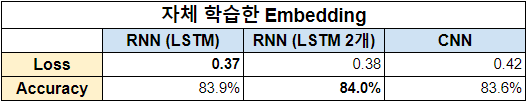

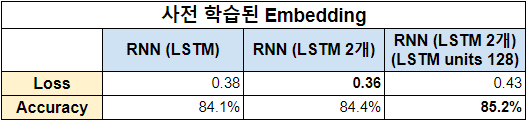

- 사전 학습된 Embedding을 활용하여 **accuracy를 85% 넘김**
- 자체 학습한 Embedding을 활용해도 accuracy를 85% 넘길 수 있을 것으로 판단됨
- 동일한 조건에서는 사전 학습된 Embedding이 자체 학습한 Embedding보다 좋은 성능을 보임

## 회고

### 1. 새로 알아갔던 점
 - 시퀀스를 다루는 딥러닝 모델로 CNN을 사용할 수 있다는 점
 - gensim 패키지를 통해 단어 유사도를 파악할 수 있다는 점
 - pre-padding이 post-padding보다 효과가 좋다는 점

### 2. 흥미로웠던 점
 - 노드에 제시된 예시 답안이 있는 줄 모르고 Data_loader를 직접 만듦
 - Mecab이 생각보다 토큰을 잘 추출하지 못했던 점 (한국어에 대한 연구가 영어에 비해 많이 부족하다는 것을 알게됨)
 - exploration04에서 활용했었던 정규식을 이용해서 문장에 필요없는 부분을 골라낸 점
 - LSTM을 두개 쓰는 방법을 알아보고 어떻게 작용하는지 찾아보는 과정이 흥미로웠음

### 3. 아쉬웠던 점
 - gensim버전에 따라 ko.bin을 인식 못하는게 아쉬웠음 (추천 버전 명시가 되었다면 좋았을 것 같다는 생각을 함)
 - gensim버전을 다운그레이드해야 ko.bin을 쓸 수 있다는 점에서 한국어에 대한 연구가 활발해졌으면 하는 소망을 함

### 4. 앞으로의 다짐
 - 한국어로 된 문장에서 토큰을 분류하는 과정이 어떻게 이뤄지는지 자세히 알아보고자 함